In [1]:
import pandas as pd

In [2]:
df_g = pd.read_csv('data/gab.csv')
df_g['response'].head(10)

0    ["Using words that insult one group while defe...
1    ['You can disagree with someones opinion witho...
2    ['Your argument is more rational if you leave ...
3    ["You shouldn't generalize a specific group or...
4    ['If someone is rude it is better to ignore th...
5    ["Please be careful with the words you choose ...
6    ["The words you've chosen are hateful and dero...
7    ['Please refrain from using such horrible bigo...
8    ['Your words are derogatory and offensive, and...
9    ["Woah! Please don't use such strong and offen...
Name: response, dtype: object

In [18]:
import pandas as pd
import ast
df_r = pd.read_csv('data/reddit.csv')
df_r['hate_speech_idx'] = df_r['hate_speech_idx'].apply(
    lambda x: ast.literal_eval(x) if pd.notnull(x) else [0]
)
df_r['response'] = df_r['response'].apply(
    lambda x: ' '.join(ast.literal_eval(x)) if pd.notnull(x) else 'There is no hatespeech in this context, No harmful or a direct attack from offensive and hate word'
)
df_r['hate_count'] = df_r['hate_speech_idx'].apply(len)
df_r.head(5)
df_r.shape

(5020, 5)

In [19]:
import pandas as pd
import re

records = []

pattern = r"\d+\.\s+(.*?)((?=\n\d+\.\s)|$)"

for idx, row in df_r.iterrows():
    id_matches = re.findall(pattern, row['id'], re.DOTALL)
    text_matches = re.findall(pattern, row['text'], re.DOTALL)

    post_ids = [match[0].strip() for match in id_matches]
    texts = [match[0].strip() for match in text_matches]


    labels = ["hate" if j + 1 in row['hate_speech_idx'] else "normal" for j in range(len(texts))]


    for post_id, text, label in zip(post_ids, texts, labels):
        records.append(((idx, row['response'], post_id), {'text': text, 'label': label}))


multi_index = pd.MultiIndex.from_tuples([r[0] for r in records], names=['context', 'response', 'post_id'])
df_nr = pd.DataFrame([r[1] for r in records], index=multi_index)
df_nr['text'] = df_nr['text'].apply(lambda x:" ".join([w.lower() for w in x.split()]))
df_nr = df_nr[~df_nr['text'].str.contains(r'\[removed\]', regex=True)]
df_nr['text'].drop_duplicates(inplace=True)
df_nr.head(4)

text  \
context response                                           post_id                                                      
0       I don't see a reason why it's okay to insult ot... e8q18lf  a subsection of retarded hungarians? ohh boy. ...   
                                                           e8q9w5s  hiii. just got off work. 444 is mainly the typ...   
                                                           e8qbobk  wow i guess soyboys are the same in every country   
                                                           e8qfn91  owen benjamin's soyboy song goes for every cou...   

                                                                     label  
context response                                           post_id          
0       I don't see a reason why it's okay to insult ot... e8q18lf    hate  
                                                           e8q9w5s  normal  
                                                           e8qbobk  normal  
                                                           e8qfn91  normal

In [20]:
import re

def clean_text(s):
    s = s.lower()
    s = re.sub(r'\d+', '', s)               # ลบตัวเลข
    s = re.sub(r'(.)\1+', r'\1', s)         # ย่ออักษรซ้ำกันต่อเนื่องให้เหลือแค่ตัวเดียว
    tokens = [w for w in s.split() if len(w) >= 2]  # กรองคำที่มีความยาวอย่างน้อย 2
    return " ".join(tokens)

df_nr['text'] = df_nr['text'].apply(clean_text)
df_nr['text'].head(5)

context  response                                                                                                                                                                                                                                  post_id
0        I don't see a reason why it's okay to insult others based on their ethnic background. Language people. You can express your ire respectfully and we insist that you do so. Thank you. Stop using mental impairments for insults on posts  e8q18lf    subsection of retarded hungarians? oh boy. bra...
                                                                                                                                                                                                                                                   e8q9w5s    hi. just got of work. is mainly the typa guys ...
                                                                                                                                             

In [21]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
df_rt = df_nr.copy()
df_rt['text'] = df_rt['text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
df_rt['text'] = df_rt['text'].apply(lambda x: re.sub(r'\[.*?\]', '', x))
stop = stopwords.words('english')
df_rt['text'] = df_rt['text'].apply(lambda x: " ".join(w for w in x.split() if w not in stop))
df_rt['new_post_id'] = df_rt.groupby('context').cumcount()+1

df_rt.head(8)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


text  \
context response                                           post_id                                                      
0       I don't see a reason why it's okay to insult ot... e8q18lf  subsection retarded hungarians oh boy brace li...   
                                                           e8q9w5s  hi got work mainly typa guys imagine writing u...   
                                                           e8qbobk                     wow gues soyboys every country   
                                                           e8qfn91  owen benjamins soyboy song goes every country ...   
1       Persons with disabilities is the accepted term.... e9c6naz  yal hear sumn al means live smal town rn work ...   
                                                           e9d8e4d  ah liberal sliped tel first question asked loa...   
2       There is no hatespeech in this context, No harm... e84rl2i  wouldnt defenders whatever group diverse group...   
                                                           e84w60l                                    inclusive white   

                                                                     label  \
context response                                           post_id           
0       I don't see a reason why it's okay to insult ot... e8q18lf    hate   
                                                           e8q9w5s  normal   
                                                           e8qbobk  normal   
                                                           e8qfn91  normal   
1       Persons with disabilities is the accepted term.... e9c6naz  normal   
                                                           e9d8e4d    hate   
2       There is no hatespeech in this context, No harm... e84rl2i  normal   
                                                           e84w60l  normal   

                                                                    new_post_id  
context response                                           post_id               
0       I don't see a reason why it's okay to insult ot... e8q18lf            1  
                                                           e8q9w5s            2  
                                                           e8qbobk            3  
                                                           e8qfn91            4  
1       Persons with disabilities is the accepted term.... e9c6naz            1  
                                                           e9d8e4d            2  
2       There is no hatespeech in this context, No harm... e84rl2i            1  
                                                           e84w60l            2

In [22]:
import random
import numpy as np
index_split = np.asarray(df_rt.index.get_level_values('context').value_counts().index)
np.random.shuffle(index_split)
train = round(index_split.shape[0]*0.8)
test = round(index_split.shape[0]*0.2)
print(train,test,train+test,index_split.shape[0])

4016 1004 5020 5020


In [23]:
df_train = df_rt.loc[index_split[:train]]
df_test = df_rt.loc[index_split[train:]]
df_test.index.get_level_values('context').value_counts().index

Index([3207,  601, 4355, 1384, 2342,  887, 4996, 1760, 4300, 1783,
       ...
       1515, 3314, 2899,  211, 2361,  872, 3203, 1914, 4442, 4133],
      dtype='int64', name='context', length=1004)

In [24]:
def context2str (df):
    df_reset = df.reset_index()

    grouped = df_reset.groupby('context')

    context_strings = []

    for context, group in grouped:
        response_text = group.iloc[0]['response']
        thread = group
        parts = [
            f"text_{row['new_post_id']} : {row['text']} is {row['label']} speech." for _, row in group.iterrows()
        ]
        combined = " ".join(parts) + f" ,response : {response_text}"
        context_strings.append(combined)
    return context_strings

In [25]:
str_train = context2str(df_train)
str_train[:5]

["text_1 : subsection retarded hungarians oh boy brace livid bulbasaur coming trying hate hole stupider countrymen is hate speech. text_2 : hi got work mainly typa guys imagine writing us stupid sites basicaly try fit western european us big city hipsters rich kids budapest fel brave journalistic heroes is normal speech. text_3 : wow gues soyboys every country is normal speech. text_4 : owen benjamins soyboy song goes every country thats amazing is normal speech. ,response : I don't see a reason why it's okay to insult others based on their ethnic background. Language people. You can express your ire respectfully and we insist that you do so. Thank you. Stop using mental impairments for insults on posts",
 'text_1 : yal hear sumn al means live smal town rn work people originaly mining comunity one protesting nobody mentioned protest today nobody cares theyre busy loving family working hard thank god electoral colege liberals think dont mater is normal speech. text_2 : ah liberal sliped

In [26]:
df_test = df_test.reset_index()[['text','label']]
df_test.head(5)

,text,label
0,nothing wil work ive tried idiot geting maried...,hate
1,da plane da plane,normal
2,sems right al godamned fagots redit,hate
3,stil get taste,normal
4,hate spech laws censorship alowed say whatever...,hate


In [32]:
text_data = str_train[0:800]

In [33]:
text_data

["text_1 : subsection retarded hungarians oh boy brace livid bulbasaur coming trying hate hole stupider countrymen is hate speech. text_2 : hi got work mainly typa guys imagine writing us stupid sites basicaly try fit western european us big city hipsters rich kids budapest fel brave journalistic heroes is normal speech. text_3 : wow gues soyboys every country is normal speech. text_4 : owen benjamins soyboy song goes every country thats amazing is normal speech. ,response : I don't see a reason why it's okay to insult others based on their ethnic background. Language people. You can express your ire respectfully and we insist that you do so. Thank you. Stop using mental impairments for insults on posts",
 'text_1 : yal hear sumn al means live smal town rn work people originaly mining comunity one protesting nobody mentioned protest today nobody cares theyre busy loving family working hard thank god electoral colege liberals think dont mater is normal speech. text_2 : ah liberal sliped

TEST

In [34]:
from langchain_core.documents import Document
from langchain_ollama import OllamaEmbeddings
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
import faiss
from uuid import uuid4
import numpy as np

# เตรียม embedding model
embeddings = OllamaEmbeddings(model="nomic-embed-text")

# กำหนดขนาดเวกเตอร์ (vector dimension)
dimension = len(embeddings.embed_query("hello world"))
index = faiss.IndexFlatL2(dimension)

# ใส่ text_data ทั้งหมด (รวม response) เป็นเอกสาร
docs = [
        Document(page_content=text)
        for text in text_data
    ]

In [35]:
uuids = [str(uuid4()) for _ in range(len(docs))]

# สร้าง vector store
vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

In [36]:
vector_store.add_documents(documents=docs, ids=uuids)

['b06ec75e-bf03-4c75-97a6-1e1ce99fb73b',
 '628dac07-fcf5-400d-83d0-d78941520ea6',
 '7dd76567-3fec-4d9c-872b-5816a3a7ca16',
 '7f5073f4-5de2-4cea-9c2c-828a9ccb1861',
 'dbb998d9-1b02-4a2b-8b83-24c1f0fc52be',
 '45ca5135-76f8-4c65-bd3c-b0a5bf4555ff',
 '4f9593b2-c76c-4009-abb9-14835fc8511a',
 '57b91361-0fc7-42d1-bcd4-8cfb6bcc2f26',
 '641e2b95-46b5-4ede-aa6d-fc65ed1d97c1',
 'cef5c881-24d0-49d1-8ff7-e4a4c44f361c',
 'c3c6c357-3adf-409a-aacd-66d6513e0e81',
 'af3f51c3-6a46-4626-bc47-9d428424aba8',
 '17620ea0-5477-4f5e-88f2-5726b428f3a9',
 'cee6777f-daf2-4130-ae28-1dd4bd834ed6',
 'e70c657d-5adc-41bc-a05b-567a3d6b8539',
 '58344f5d-7e32-4563-8484-66ed1094a05e',
 'ccf4c314-8b04-49a3-9800-2eafae378256',
 '19b3afc7-0c39-4101-9166-edec6bdeec24',
 '3ce202e0-25e8-4b6c-ac98-aab6c7327495',
 'b6335fb6-fe95-4243-8353-9e2a7c5a9b8a',
 '5d01e862-700a-4074-873b-106f4191d9bf',
 'b207069b-9519-4c4b-80a2-bce0c3098f8e',
 'd18fd39b-3fb7-4d92-8f29-a5f4baaefa42',
 '9868c46b-e475-47a0-9310-dadc5b39efe0',
 '82f78470-2b04-

In [37]:
import ollama
def gemma3RAG(context,retrieve):
    prompt = f"""
    Here is some example of context about hate speech and it's human response:
    {retrieve}

    Is the following comment hate speech?
    "{context}"

    Please answer in the format: 
    {{"label": "hate" or "normal", "explanation": "<reasoning>"}}
    """
    response = ollama.generate(
        model='gemma3:1b',
        prompt=prompt,
        system="""
                "You are a general LLM for hate speech classification from user context input with the retrieved data.",
                "You can classify the sentence and give the explaination of it",
                "Profane words do not automatically imply hatespeech or offensive. You must consider the overall sentiment, context, and intent for generate answer.",
                "The reason that you give can be explaination keyword using or suggestion"
                """,
        options={
            "temperature": 0,
            "top_p": 0.8,
            "top_k": 50,
            "num_predict": 400,     # max_tokens
            "seed": 42
        }
    )
    return response['response']

def gemma3(context):
    prompt = f"""
    Is the following comment hate speech?
    "{context}"

    Please answer in the format: 
    {{"label": "hate" or "normal", "explanation": "<reasoning>"}}
    """
    response = ollama.generate(
        model='gemma3:1b',
        prompt=prompt,
        system="""
                "You are a general LLM for hate speech classification from user context input",
                "You can classify the sentence and give the explaination of it",
                "Profane words do not automatically imply hate speech. You must consider the overall sentiment, context, and intent.",
                "The reason that you give can be explaination keyword using or suggestion"
                """,
        options={
            "temperature": 0,
            "top_p": 0.8,
            "top_k": 50,
            "num_predict": 400,     # max_tokens
            "seed": 42
        }
    )
    return response['response']

In [174]:
# context = df_train['text'][0]
context = df_train.reset_index()['text'][0]
#context = "because the japanese aren't retarded and know that *fictional characters* aren't owed anything, much less dignity."
gemma3(context)

'{"label": "hate", "explanation": "The comment uses offensive and derogatory language targeting a person based on their perceived characteristics (old, nasty, twat, jay). This is a clear expression of hate and is likely intended to cause harm or distress."}'

In [176]:
retriever = vector_store.as_retriever(search_kwargs={"k": 4})
retrieved_docs = retriever.invoke(context)
retrieved_context = "\n".join([doc.page_content for doc in retrieved_docs])
retrieve_data = retrieved_context
gemma3RAG(context, retrieve_data)

'{"label": "hate", "explanation": "The comment uses a derogatory term \'twat\' and expresses a desire for harm to someone (Jay and Gina). This is a clear indication of hate speech due to its aggressive and offensive nature."}'

In [177]:
retrieve_data

"text_1 : ill agree rick couple people know say hes one favorite characters insufferable twats is hate speech. text_2 : fair is normal speech. text_3 : dont is normal speech. text_4 : wait dont remember typing is normal speech. text_5 : like rick drunk is normal speech. text_6 : always like rick is normal speech. text_7 : extra drunk is normal speech. text_8 : dan harmon justin roiland commits method edit fml forgot va is normal speech. text_9 : justin roiland harmon writes roiland acts is normal speech. text_10 : crap thank is normal speech. text_11 : good sith happens remember ive watched video roiland getting wasted method act rick is normal speech. ,response : Using the word 'twat' is offensive as its a direct attack to someone based on their gender. Refrain from such words I don't think using words that are sexist in nature contribute to a productive conversation.\ntext_1 : forgot lying cunt haha would good match crazy eyeshttpsmemegeneratornetcrazyeyesbigdaddy is hate speech. ,re

In [38]:
No_RAG = []
With_RAG = []
for context in df_test['text'].tolist()[:150]:
    No_RAG.append(gemma3(context))
    retriever = vector_store.as_retriever(search_kwargs={"k": 6})
    retrieved_docs = retriever.invoke(context)
    retrieved_context = "\n".join([doc.page_content for doc in retrieved_docs])
    retrieve_data = retrieved_context
    With_RAG.append(gemma3RAG(context, retrieve_data))

In [45]:
import json
import ast

No_RAG_list = []
for i, item in enumerate(No_RAG):
    try:
        clean_item = item.replace("“", '"').replace("”", '"')
        clean_item = item.replace("“", "'").replace("”", "'")
        parsed = ast.literal_eval(clean_item)  # หรือ json.loads(clean_item)
        No_RAG_list.append(parsed['label'])
    except Exception as e:
        print(f"Error at index {i}: {e}")
        print("Raw item:", repr(item))

In [46]:
RAG_list = []
for i, item in enumerate(With_RAG):
    try:
        clean_item = item.replace("“", '"').replace("”", '"')
        clean_item = item.replace("“", "'").replace("”", "'")
        parsed = ast.literal_eval(clean_item)  # หรือ json.loads(clean_item)
        RAG_list.append(parsed['label'])
    except Exception as e:
        print(f"Error at index {i}: {e}")
        print("Raw item:", repr(item))

In [52]:
df_compareR = pd.DataFrame({'pred':RAG_list,'test':df_test['label'][:150].tolist()})
df_compareR.loc[df_compareR['pred'] == 'hate', 'pred'] = 'hatespeech'
df_compareNR = pd.DataFrame({'pred':No_RAG_list,'test':df_test['label'][:150].tolist()})
df_compareNR.loc[df_compareNR['pred'] == 'hate', 'pred'] = 'hatespeech'
# df_compare

Accuracy: 0.13


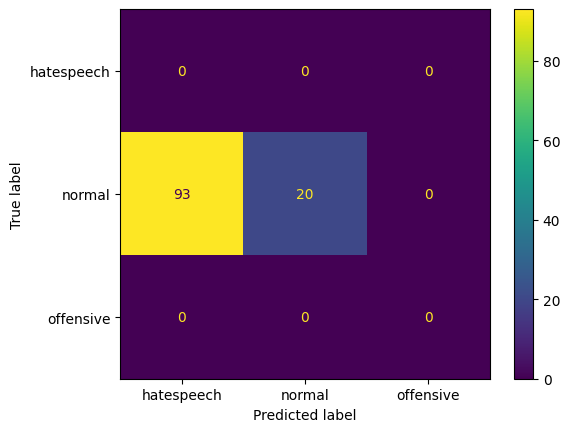

In [53]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Accuracy
acc = accuracy_score(df_compareR['test'], df_compareR['pred'])
print(f"Accuracy: {acc:.2f}")

# Confusion matrix
cm = confusion_matrix(df_compareR['test'], df_compareR['pred'], labels=["hatespeech","normal", "offensive"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["hatespeech","normal", "offensive"])
disp.plot()

Accuracy: 0.30


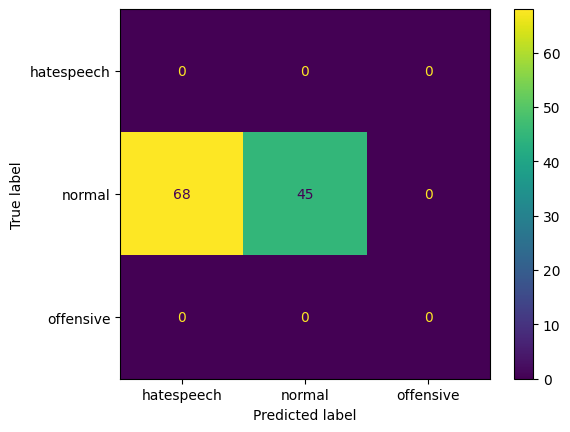

In [54]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Accuracy
acc = accuracy_score(df_compareNR['test'], df_compareNR['pred'])
print(f"Accuracy: {acc:.2f}")

# Confusion matrix
cm = confusion_matrix(df_compareNR['test'], df_compareNR['pred'], labels=["hatespeech","normal", "offensive"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["hatespeech","normal", "offensive"])
disp.plot()

<Axes: >

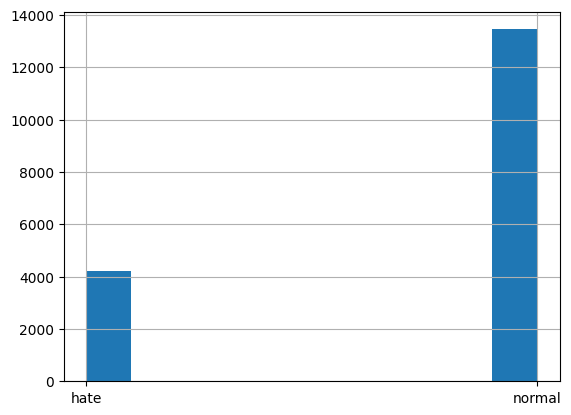

In [58]:
df_train.reset_index()['label'].hist()

<Axes: >

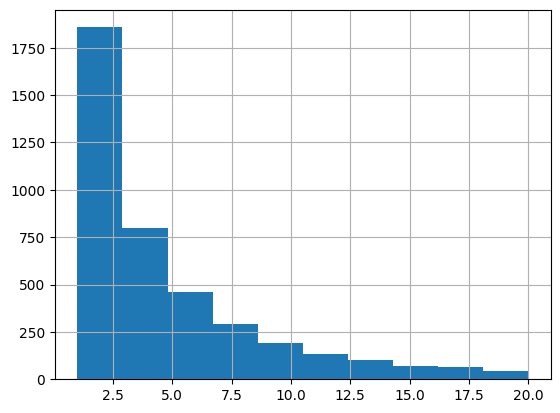

In [59]:
df_train.reset_index()['context'].value_counts().hist()

In [60]:
df_train

text  \
context response                                           post_id                                                      
4988    It is absurd and extremely harmful to reduce ac... e82bexa  oh lok another dumb cunt trying play sexual as...   
3655    "Ret---ed" and "c--t" as used here are offensiv... e6uqu6g                                            deleted   
                                                           e6us1he  fair feminists know personaly al totaly reason...   
                                                           e6uy5h8                                       name problem   
                                                           e6uyxtb  almost half americans think woman get pregnant...   
...                                                                                                               ...   
2397    Watch the language. This is not acceptable. Gen... e285cjy  course man refuses white knight use modern tra...   
                                                           e2834k5  could probably fuck daughter long shes got cha...   
                                                           e29xu74                   men standards cunts would incels   
1487    "Re---d" as used here debases the speaker and m... e6vnp78  definitely majority right wing posters right w...   
                                                           e6wfm6c  im leftwing anarchotranshumanist trans bisexua...   

                                                                     label  \
context response                                           post_id           
4988    It is absurd and extremely harmful to reduce ac... e82bexa    hate   
3655    "Ret---ed" and "c--t" as used here are offensiv... e6uqu6g  normal   
                                                           e6us1he  normal   
                                                           e6uy5h8  normal   
                                                           e6uyxtb  normal   
...                                                                    ...   
2397    Watch the language. This is not acceptable. Gen... e285cjy    hate   
                                                           e2834k5  normal   
                                                           e29xu74    hate   
1487    "Re---d" as used here debases the speaker and m... e6vnp78  normal   
                                                           e6wfm6c    hate   

                                                                    new_post_id  
context response                                           post_id               
4988    It is absurd and extremely harmful to reduce ac... e82bexa            1  
3655    "Ret---ed" and "c--t" as used here are offensiv... e6uqu6g            1  
                                                           e6us1he            2  
                                                           e6uy5h8            3  
                                                           e6uyxtb            4  
...                                                                         ...  
2397    Watch the language. This is not acceptable. Gen... e285cjy           18  
                                                           e2834k5           19  
                                                           e29xu74           20  
1487    "Re---d" as used here debases the speaker and m... e6vnp78            1  
                                                           e6wfm6c            2  

[17665 rows x 3 columns]

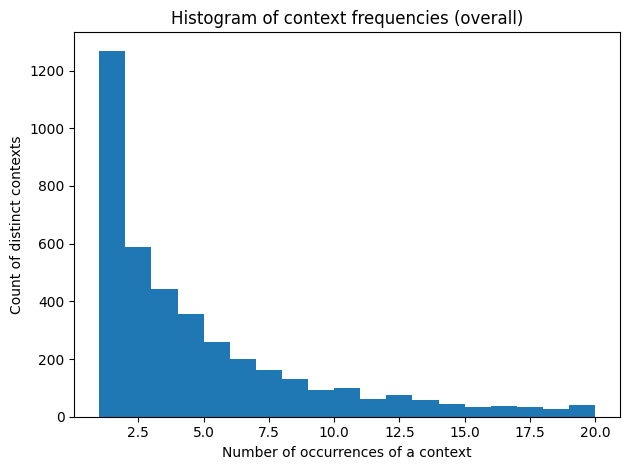

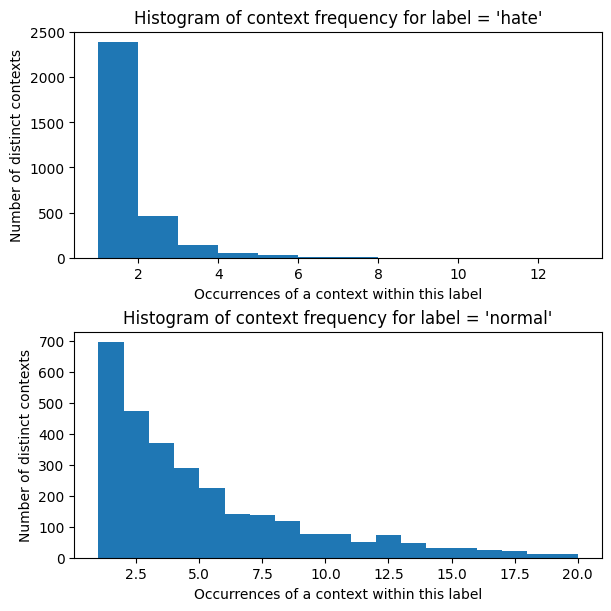

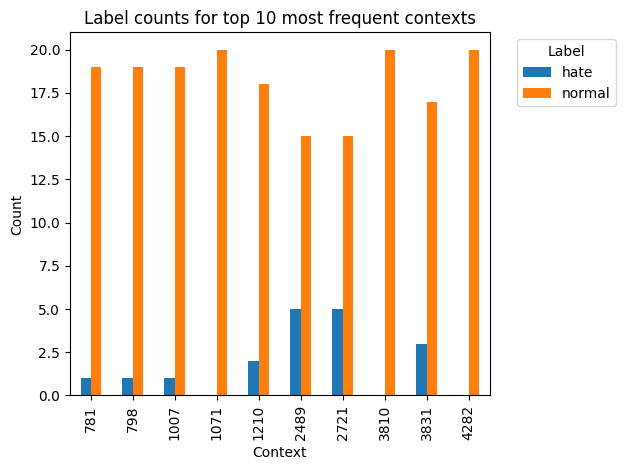

In [ ]:
import matplotlib.pyplot as plt

# สมมติ df_train มีคอลัมน์ at least: 'context', 'label'
df = df_train.reset_index()

# 1. Histogram ของความถี่ของ context ทั้งหมด (จำนวนครั้งที่แต่ละ context ปรากฏ)
context_counts = df['context'].value_counts()
fig1, ax1 = plt.subplots()
ax1.hist(context_counts.values, bins='auto')
ax1.set_title("Histogram of context frequencies (overall)")
ax1.set_xlabel("Number of occurrences of a context")
ax1.set_ylabel("Count of distinct contexts")
plt.tight_layout()
plt.show()

# 2. Histogram แยกตาม label: ดู distribution ของความถี่ของ context ภายในแต่ละ label
grouped = df.groupby('label')['context'].value_counts()  # Series with MultiIndex

labels = sorted(df['label'].unique())
fig2, axes2 = plt.subplots(len(labels), 1, figsize=(6, 3 * len(labels)), constrained_layout=True)
if len(labels) == 1:
    axes2 = [axes2]

for ax, label in zip(axes2, labels):
    # ดึงความถี่ของ context ภายใน label นั้น
    counts = grouped[label].values if label in grouped.index.levels[0] else []
    ax.hist(counts, bins='auto')
    ax.set_title(f"Histogram of context frequency for label = '{label}'")
    ax.set_xlabel("Occurrences of a context within this label")
    ax.set_ylabel("Number of distinct contexts")

plt.show()

# 3. เปรียบเทียบ label counts สำหรับ top N contexts ที่พบบ่อยที่สุด
top_n = 10
top_contexts = context_counts.nlargest(top_n).index
subset = df[df['context'].isin(top_contexts)]
pivot = subset.pivot_table(index='context', columns='label', aggfunc='size', fill_value=0)

fig3, ax3 = plt.subplots()
pivot.plot(kind='bar', stacked=False, ax=ax3)
ax3.set_title(f"Label counts for top {top_n} most frequent contexts")
ax3.set_xlabel("Context")
ax3.set_ylabel("Count")
ax3.legend(title="Label", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()